<a href="https://colab.research.google.com/github/nidduzzi/open-ended-neural-nets/blob/main/Julia_1_6_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Installation cell
%%capture
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget -q 'https://julialang-s3.julialang.org/bin/linux/x64/1.6/julia-1.6.0-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'
echo 'Done'

After you run the first cell (the the cell directly above this text), go to Colab's menu bar and select **Edit** and select **Notebook settings** from the drop down. Select *Julia 1.6* in Runtime type. You can also select your prefered harwdware acceleration (defaults to GPU). 

<br/>You should see something like this:

> ![Colab Img](https://raw.githubusercontent.com/Dsantra92/Julia-on-Colab/master/misc/julia_menu.png)

<br/>Click on SAVE
<br/>**We are ready to get going**





In [1]:
VERSION

v"1.6.0"

**The next three cells are for GPU benchmarking. If you are using this notebook for the first time and have GPU enabled, you can give it a try.** 

### Optional GPU Experiments

In [1]:
using Pkg
Pkg.add(["BenchmarkTools","Random", "Distributions", "GPUArrays", "CUDA", "NNlib", "ProgressMeter", "Images", "Plots", "MLDatasets", "Profile", "Flux"])
using Random, Distributions, Markdown, Images, Plots, MLDatasets, Profile, GPUArrays, Flux, CUDA, BenchmarkTools


if has_cuda_gpu()
  print("The GPU device is:", CUDA.device())
end

SyntaxError: ignored

In [4]:
mcpu = rand(2^10, 2^10)
@benchmark mcpu*mcpu

BenchmarkTools.Trial: 
  memory estimate:  8.00 MiB
  allocs estimate:  2
  --------------
  minimum time:     51.640 ms (0.00% GC)
  median time:      53.984 ms (0.00% GC)
  mean time:        55.070 ms (0.74% GC)
  maximum time:     68.483 ms (0.00% GC)
  --------------
  samples:          91
  evals/sample:     1

In [5]:
println("The CuArrray operation should take around 0.5 ms(excluding CUDA downloading time which is a one time process), and should be much faster. If so, the GPU is working.")
mgpu = cu(mcpu)
@benchmark CUDA.@sync mgpu*mgpu

The CuArrray operation should take around 0.5 ms(excluding CUDA downloading time which is a one time process), and should be much faster. If so, the GPU is working.


BenchmarkTools.Trial: 
  memory estimate:  896 bytes
  allocs estimate:  37
  --------------
  minimum time:     488.209 μs (0.00% GC)
  median time:      623.018 μs (0.00% GC)
  mean time:        633.088 μs (0.16% GC)
  maximum time:     10.529 ms (36.93% GC)
  --------------
  samples:          7735
  evals/sample:     1

In [9]:
@benchmark mgpu*mgpu

BenchmarkTools.Trial: 
  memory estimate:  832 bytes
  allocs estimate:  34
  --------------
  minimum time:     15.385 μs (0.00% GC)
  median time:      608.892 μs (0.00% GC)
  mean time:        590.217 μs (0.15% GC)
  maximum time:     7.868 ms (47.83% GC)
  --------------
  samples:          8409
  evals/sample:     1

In [8]:
allowscalar(false)

In [10]:
train_x, train_y = MNIST.traindata(Float16)
train_y = [Flux.onehot(i, collect(0:9)) for i in train_y]

60000-element Vector{Flux.OneHotArray{UInt32, 10, 0, 1, UInt32}}:
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
 ⋮
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

In [11]:
n_size = length(train_x[:,:,1]) + 64 + 128 + 16 + 64 + 64 + 4000 # network size with pytorch

5120

In [1]:
numInput = 60000
idx = sample(1:size(train_x)[3], numInput, replace = false)
samp = reduce(hcat, [train_x[:,:, i][:] for i in idx])
samplingRate = Int(numInput//100)

LoadError: ignored

In [48]:
include("/content/network.jl")

In [60]:
network = NetworkModule.Network{Array}(n_size, 0.0218, 0.0001)
gpuNetwork = NetworkModule.Network{CuArray}(n_size, 0.0218, 0.0001)
NetworkModule.network_copy!(gpuNetwork, network)

In [ ]:
result = NetworkModule.propagate!(gpuNetwork, cu(samp), 10, ϵ=0.001, samplingRate=samplingRate)

current network input length is smaller than input length, adding 784
current network output length is smaller than output length, adding 10
number of input: 60000
input_length: 784
output_size: 10


Progress:  15%|██████                                   |  ETA: 0:29:47

In [53]:
result[2]

10-element Vector{Vector{Float16}}:
 [0.517, 0.5386, 0.516, 0.5205, 0.4888, 0.52, 0.5605, 0.5264, 0.509, 0.4832]
 [0.4897, 0.4941, 0.4958, 0.5044, 0.4888, 0.5215, 0.5103, 0.5073, 0.4988, 0.4927]
 [0.472, 0.473, 0.4727, 0.5015, 0.4858, 0.5063, 0.4773, 0.507, 0.489, 0.5044]
 [0.4824, 0.4841, 0.476, 0.4978, 0.4893, 0.4814, 0.4702, 0.5015, 0.4917, 0.5063]
 [0.506, 0.497, 0.4897, 0.494, 0.5015, 0.4827, 0.4875, 0.495, 0.495, 0.4998]
 [0.5215, 0.4993, 0.4956, 0.5, 0.5127, 0.4912, 0.4983, 0.4922, 0.4966, 0.5044]
 [0.5107, 0.5063, 0.504, 0.505, 0.513, 0.486, 0.5107, 0.4778, 0.5024, 0.509]
 [0.498, 0.5063, 0.4985, 0.502, 0.5024, 0.498, 0.498, 0.4775, 0.515, 0.508]
 [0.492, 0.505, 0.504, 0.4983, 0.5015, 0.51, 0.4807, 0.4944, 0.519, 0.4995]
 [0.4902, 0.493, 0.513, 0.4954, 0.51, 0.507, 0.4954, 0.509, 0.5127, 0.499]

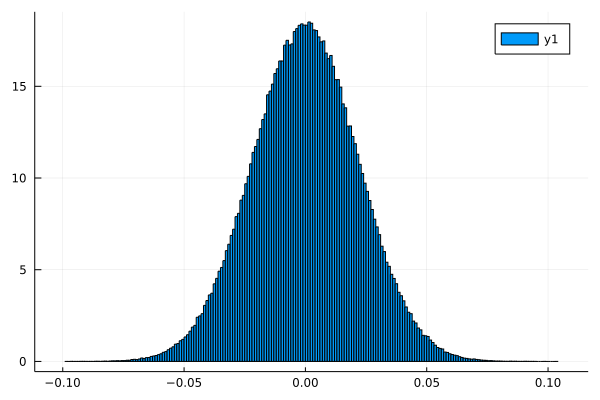

In [54]:
histogram(Array(network.w[network.α]), normalize=true)

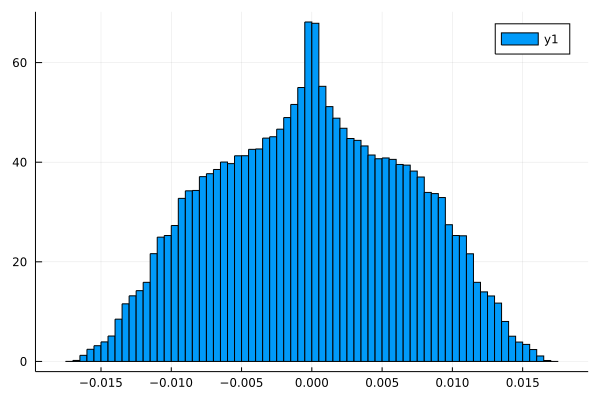

In [55]:
histogram(Array(gpuNetwork.w[gpuNetwork.α]), normalize=true)

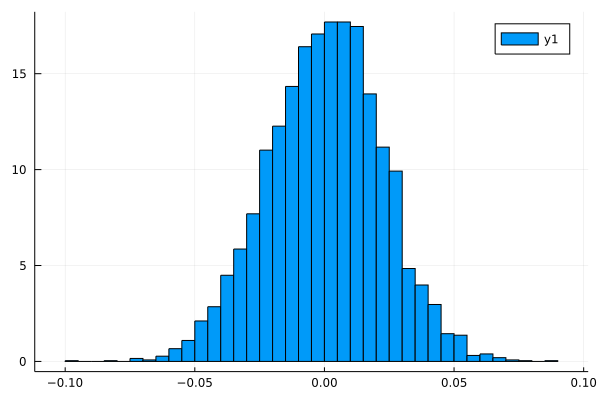

In [58]:
histogram(network.b, normalize=true)

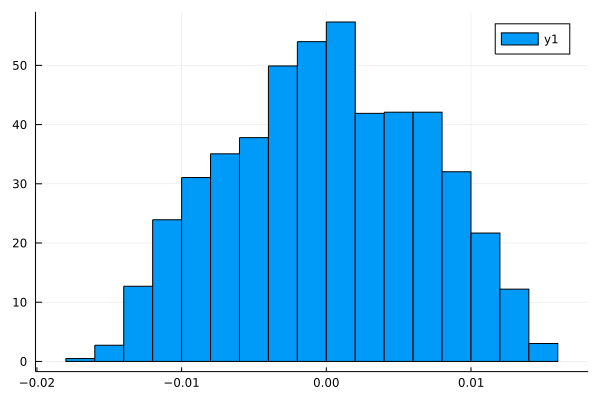

In [57]:
histogram(Array(gpuNetwork.b), normalize=true)

In [ ]:
exit()